In [ ]:
# NOTEBOOK 3: GRADIENT BOOSTING CON ANÁLISIS AVANZADO
# Enfoque: Gradient Boosting + LightGBM con análisis estadístico profundo
# OPTIMIZADO PARA MEMORIA LIMITADA + GENERACIÓN DE PREDICCIONES KAGGLE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configurar matplotlib para usar menos memoria
plt.rcParams['figure.max_open_warning'] = 0

# Intentar importar LightGBM (opcional)
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("LightGBM disponible")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM no disponible, usando solo Gradient Boosting")

print("="*80)
print("NOTEBOOK 3: GRADIENT BOOSTING CON ANÁLISIS AVANZADO - OPTIMIZADO + KAGGLE")
print("="*80)

In [ ]:
# CARGA Y PREPROCESAMIENTO DE DATOS - OPTIMIZADO
print("\n1. CARGA DE DATOS ORIGINALES")
print("-" * 40)

# Cargar datos con optimización de memoria
try:
    # Cargar datos de entrenamiento
    df_train = pd.read_csv('train.csv', low_memory=False)
    print(f"Datos de entrenamiento cargados: {df_train.shape[0]} filas x {df_train.shape[1]} columnas")

    # Cargar datos de test
    df_test = pd.read_csv('test.csv', low_memory=False)
    print(f"Datos de test cargados: {df_test.shape[0]} filas x {df_test.shape[1]} columnas")

    # Verificar que tengan las mismas columnas (excepto la variable objetivo)
    train_cols = set(df_train.columns)
    test_cols = set(df_test.columns)

    # Identificar columna objetivo (debe estar en train pero no en test)
    target_candidates = train_cols - test_cols
    if len(target_candidates) == 1:
        target_column = list(target_candidates)[0]
        print(f"Columna objetivo detectada automáticamente: {target_column}")
    else:
        # Si no se detecta automáticamente, usar el valor por defecto
        target_column = 'RENDIMIENTO_GLOBAL'
        if target_column not in df_train.columns:
            print(f"Error: Columna objetivo '{target_column}' no encontrada")
            possible_targets = [col for col in df_train.columns if 'RENDIMIENTO' in str(col).upper()]
            if possible_targets:
                target_column = possible_targets[0]
                print(f"Usando columna: {target_column}")
            else:
                raise ValueError("No se encontró columna objetivo")

    # Verificar columna de ID en test
    id_column = None
    id_candidates = ['ID', 'Id', 'id', 'INDEX', 'index']
    for col in id_candidates:
        if col in df_test.columns:
            id_column = col
            break

    if id_column is None:
        # Si no hay columna ID explícita, usar el índice
        print("No se encontró columna ID, usando índice como ID")
        df_test['ID'] = df_test.index
        id_column = 'ID'

    print(f"Columna ID: {id_column}")

    # Optimizar tipos de datos para reducir memoria
    def optimize_dtypes(df):
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].astype('category')
            elif df[col].dtype == 'int64':
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif df[col].dtype == 'float64':
                df[col] = pd.to_numeric(df[col], downcast='float')
        return df

    df_train = optimize_dtypes(df_train)
    df_test = optimize_dtypes(df_test)

    print(f"Memoria optimizada train: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"Memoria optimizada test: {df_test.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Asegúrate de tener los archivos 'train.csv' y 'test.csv' en el directorio.")
    raise

In [ ]:
# ANÁLISIS INICIAL Y PREPROCESAMIENTO - OPTIMIZADO
print("\n2. ANÁLISIS INICIAL Y PREPROCESAMIENTO")
print("-" * 40)

# Configurar variables
columns_to_drop = [id_column] if id_column in df_train.columns else []

print(f"Columna objetivo: {target_column}")
print(f"Columna ID: {id_column}")

# Combinar datos para preprocesamiento conjunto
print("Combinando datos para preprocesamiento conjunto...")

# Guardar IDs de test
test_ids = df_test[id_column].copy()

# Marcar origen de los datos
df_train['__dataset_source__'] = 'train'
df_test['__dataset_source__'] = 'test'

# Agregar columna objetivo vacía al test
df_test[target_column] = -1

# Combinar datasets
df_combined = pd.concat([df_train, df_test], ignore_index=True, sort=False)
print(f"Datos combinados: {df_combined.shape}")

# Análisis de valores nulos (optimizado)
null_counts = df_combined.isnull().sum()
print(f"Columnas con valores nulos: {(null_counts > 0).sum()}")

# Identificar tipos de columnas (excluyendo columnas de control)
exclude_cols = columns_to_drop + [target_column, '__dataset_source__']
categorical_cols = df_combined.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df_combined.select_dtypes(include=['number']).columns.tolist()

categorical_cols = [col for col in categorical_cols if col not in exclude_cols]
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Columnas categóricas: {len(categorical_cols)}")
print(f"Columnas numéricas: {len(numeric_cols)}")

In [ ]:
# PREPROCESAMIENTO CONJUNTO
print("\n3. PREPROCESAMIENTO CONJUNTO")
print("-" * 40)

# Crear una copia para trabajar
df_work = df_combined.copy()

# Imputar valores nulos en columnas numéricas
if numeric_cols:
    print("Procesando columnas numéricas...")
    for col in numeric_cols:
        if df_work[col].isnull().sum() > 0:
            # Calcular mediana solo en datos de entrenamiento
            train_mask = df_work['__dataset_source__'] == 'train'
            median_val = df_work.loc[train_mask, col].median()
            df_work[col].fillna(median_val, inplace=True)
    print(f"{len(numeric_cols)} columnas numéricas procesadas")

# Imputar valores nulos en columnas categóricas
if categorical_cols:
    print("Procesando columnas categóricas...")
    for col in categorical_cols:
        if df_work[col].isnull().sum() > 0:
            # Calcular moda solo en datos de entrenamiento
            train_mask = df_work['__dataset_source__'] == 'train'
            train_values = df_work.loc[train_mask, col]
            mode_val = train_values.mode()[0] if len(train_values.mode()) > 0 else 'UNKNOWN'
            df_work[col].fillna(mode_val, inplace=True)
    print(f"{len(categorical_cols)} columnas categóricas procesadas")

# One-hot encoding optimizado
if categorical_cols:
    print("Aplicando One-Hot Encoding optimizado...")
    cols_to_encode = []
    train_mask = df_work['__dataset_source__'] == 'train'

    for col in categorical_cols:
        # Analizar solo datos de entrenamiento para determinar categorías
        train_values = df_work.loc[train_mask, col]
        n_unique = train_values.nunique()

        if n_unique <= 20:
            cols_to_encode.append(col)
        else:
            # Para columnas con muchas categorías, usar solo las más frecuentes
            top_categories = train_values.value_counts().head(10).index
            df_work[col] = df_work[col].apply(lambda x: x if x in top_categories else 'OTHER')
            cols_to_encode.append(col)

    if cols_to_encode:
        df_encoded = pd.get_dummies(df_work, columns=cols_to_encode, drop_first=True, sparse=True)
        # Convertir sparse a dense si es necesario
        if hasattr(df_encoded, 'sparse'):
            df_encoded = df_encoded.sparse.to_dense()
        print(f"Encoding aplicado a {len(cols_to_encode)} columnas")
    else:
        df_encoded = df_work.copy()
else:
    df_encoded = df_work.copy()

del df_work, df_combined  # Liberar memoria

# Normalización de variables numéricas
if numeric_cols:
    print("Normalizando columnas numéricas...")
    train_mask = df_encoded['__dataset_source__'] == 'train'

    scaler = StandardScaler()
    # Ajustar scaler solo con datos de entrenamiento
    scaler.fit(df_encoded.loc[train_mask, numeric_cols])
    # Aplicar a todos los datos
    df_encoded[numeric_cols] = scaler.transform(df_encoded[numeric_cols])
    print(f"{len(numeric_cols)} columnas numéricas normalizadas")

print(f"Preprocesamiento completado: {df_encoded.shape}")

In [ ]:
# SEPARAR DATOS PROCESADOS
print("\n4. SEPARAR DATOS PROCESADOS")
print("-" * 40)

# Separar train y test
train_mask = df_encoded['__dataset_source__'] == 'train'
test_mask = df_encoded['__dataset_source__'] == 'test'

df_train_processed = df_encoded[train_mask].copy()
df_test_processed = df_encoded[test_mask].copy()

# Limpiar columnas de control
exclude_final = ['__dataset_source__'] + columns_to_drop
X_train_full = df_train_processed.drop(columns=[target_column] + exclude_final)
y_train_full = df_train_processed[target_column]
X_test_full = df_test_processed.drop(columns=[target_column] + exclude_final)

del df_encoded, df_train_processed, df_test_processed  # Liberar memoria

print(f"Datos de entrenamiento: {X_train_full.shape}")
print(f"Datos de test: {X_test_full.shape}")

In [ ]:
# SELECCIÓN DE CARACTERÍSTICAS - OPTIMIZADO
print("\n5. SELECCIÓN DE CARACTERÍSTICAS")
print("-" * 40)

# Codificar variable objetivo
le = LabelEncoder()
if y_train_full.dtype == 'object' or y_train_full.dtype.name == 'category':
    y_encoded = le.fit_transform(y_train_full)
    class_names = le.classes_
else:
    y_encoded = y_train_full.values
    class_names = sorted(y_train_full.unique())

print(f"Características iniciales: {X_train_full.shape[1]}")
print(f"Clases objetivo: {class_names}")

# Selección de características más agresiva para ahorrar memoria
print("Seleccionando características más relevantes...")

max_features = min(100, X_train_full.shape[1])

if X_train_full.shape[1] > max_features:
    selector = SelectKBest(score_func=mutual_info_classif, k=max_features)
    X_train_selected = selector.fit_transform(X_train_full, y_encoded)
    X_test_selected = selector.transform(X_test_full)

    selected_feature_names = X_train_full.columns[selector.get_support()].tolist()
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_feature_names)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_feature_names)

    print(f"Características reducidas de {X_train_full.shape[1]} a {max_features}")
else:
    X_train_selected = X_train_full.copy()
    X_test_selected = X_test_full.copy()
    selected_feature_names = X_train_full.columns.tolist()

del X_train_full, X_test_full  # Liberar memoria

In [ ]:
# DIVISIÓN DE DATOS PARA VALIDACIÓN
print("\n6. DIVISIÓN DE DATOS PARA VALIDACIÓN")
print("-" * 40)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de validación: {X_val.shape}")
print(f"Datos de test final: {X_test_selected.shape}")

In [ ]:
# ENTRENAMIENTO DE MODELOS
print("\n7. ENTRENAMIENTO DE MODELOS")
print("-" * 40)

# Parámetros optimizados para memoria
gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 4,
    'subsample': 0.8,
    'max_features': 'sqrt',
    'random_state': 42
}

print("Entrenando Gradient Boosting...")
gb_model = GradientBoostingClassifier(**gb_params)
gb_model.fit(X_train, y_train)

# Predicciones en validación
y_pred_gb = gb_model.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

print(f"Gradient Boosting - Precisión: {accuracy_gb:.4f}")
print(f"Gradient Boosting - F1-Score: {f1_gb:.4f}")

In [ ]:
# LIGHTGBM (SI ESTÁ DISPONIBLE)
best_accuracy = accuracy_gb
best_model = gb_model
best_model_name = "Gradient Boosting"

if LIGHTGBM_AVAILABLE:
    print("\n8. ENTRENAMIENTO LIGHTGBM")
    print("-" * 40)

    lgb_params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_encoded)),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 20,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42,
        'force_row_wise': True
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    print("Entrenando LightGBM...")
    lgb_model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, val_data],
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
    )

    # Predicciones en validación
    y_pred_lgb_prob = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    y_pred_lgb = np.argmax(y_pred_lgb_prob, axis=1)
    accuracy_lgb = accuracy_score(y_val, y_pred_lgb)
    f1_lgb = f1_score(y_val, y_pred_lgb, average='weighted')

    print(f"LightGBM - Precisión: {accuracy_lgb:.4f}")
    print(f"LightGBM - F1-Score: {f1_lgb:.4f}")

    if accuracy_lgb > best_accuracy:
        best_accuracy = accuracy_lgb
        best_model = lgb_model
        best_model_name = "LightGBM"

print(f"\nMejor modelo: {best_model_name} (Precisión: {best_accuracy:.4f})")

In [ ]:
# ENTRENAMIENTO FINAL CON TODOS LOS DATOS
print("\n9. ENTRENAMIENTO FINAL CON TODOS LOS DATOS")
print("-" * 40)

print("Entrenando modelo final con todos los datos de entrenamiento...")

if best_model_name == "Gradient Boosting":
    final_model = GradientBoostingClassifier(**gb_params)
    final_model.fit(X_train_selected, y_encoded)
else:
    # LightGBM
    final_train_data = lgb.Dataset(X_train_selected, label=y_encoded)
    final_model = lgb.train(
        lgb_params,
        final_train_data,
        num_boost_round=100,
        callbacks=[lgb.log_evaluation(0)]
    )

print("Modelo final entrenado")

In [ ]:
# GENERAR PREDICCIONES PARA KAGGLE
print("\n10. GENERAR PREDICCIONES PARA KAGGLE")
print("-" * 40)

print("Generando predicciones para el conjunto de test...")

if best_model_name == "Gradient Boosting":
    test_predictions = final_model.predict(X_test_selected)
else:
    test_predictions_prob = final_model.predict(X_test_selected)
    test_predictions = np.argmax(test_predictions_prob, axis=1)

# Convertir predicciones numéricas de vuelta a labels originales si es necesario
if hasattr(le, 'classes_'):
    test_predictions_labels = le.inverse_transform(test_predictions)
else:
    test_predictions_labels = test_predictions

print(f"Predicciones generadas: {len(test_predictions_labels)}")
print(f"Distribución de predicciones:")
unique, counts = np.unique(test_predictions_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count} ({count/len(test_predictions_labels)*100:.1f}%)")

In [ ]:
# CREAR ARCHIVO DE SUBMISSION PARA KAGGLE
print("\n11. CREAR ARCHIVO DE SUBMISSION")
print("-" * 40)

# Crear DataFrame con formato Kaggle
submission_df = pd.DataFrame({
    id_column: test_ids,
    target_column: test_predictions_labels
})

# Guardar archivo de submission
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Archivo de submission guardado: {submission_filename}")
print(f"Formato del archivo:")
print(f"  Columnas: {list(submission_df.columns)}")
print(f"  Número de filas: {len(submission_df)}")
print(f"  Primeras 5 filas:")
print(submission_df.head())

In [ ]:
# EVALUACIÓN Y ANÁLISIS FINAL
print("\n12. EVALUACIÓN Y ANÁLISIS FINAL")
print("-" * 40)

# Reporte de clasificación en validación
print("Reporte de Clasificación (validación):")
if best_model_name == "Gradient Boosting":
    val_predictions = gb_model.predict(X_val)
else:
    val_predictions_prob = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    val_predictions = np.argmax(val_predictions_prob, axis=1)

print(classification_report(y_val, val_predictions, target_names=class_names))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.tight_layout()
plt.show()
plt.close()

# Importancia de características
if best_model_name == "Gradient Boosting":
    feature_importance = pd.DataFrame({
        'feature': selected_feature_names,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    lgb_importance = final_model.feature_importance(importance_type='gain')
    feature_importance = pd.DataFrame({
        'feature': selected_feature_names,
        'importance': lgb_importance
    }).sort_values('importance', ascending=False)

print(f"\nTop 10 características más importantes:")
print(feature_importance.head(10))

# Visualizar importancia
plt.figure(figsize=(10, 6))
top_10_features = feature_importance.head(10)
plt.barh(range(len(top_10_features)), top_10_features['importance'])
plt.yticks(range(len(top_10_features)), top_10_features['feature'])
plt.xlabel('Importancia')
plt.title(f'Top 10 Características - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# VALIDACIÓN CRUZADA
print("\n13. VALIDACIÓN CRUZADA")
print("-" * 40)

cv_folds = 3
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

if best_model_name == "Gradient Boosting":
    cv_model = GradientBoostingClassifier(**gb_params)
else:
    cv_model = GradientBoostingClassifier(**gb_params)

cv_scores = cross_val_score(cv_model, X_train_selected, y_encoded, cv=skf, scoring='accuracy')

print(f"Validación Cruzada ({cv_folds} folds):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nPrecisión promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

LightGBM disponible
NOTEBOOK 3: GRADIENT BOOSTING CON ANÁLISIS AVANZADO - OPTIMIZADO + KAGGLE

1. CARGA DE DATOS ORIGINALES
----------------------------------------
Datos de entrenamiento cargados: 692500 filas x 21 columnas
Datos de test cargados: 296786 filas x 20 columnas
Columna objetivo detectada automáticamente: RENDIMIENTO_GLOBAL
Columna ID: ID
Memoria optimizada train: 25.24 MB
Memoria optimizada test: 10.61 MB

2. ANÁLISIS INICIAL Y PREPROCESAMIENTO
----------------------------------------
Columna objetivo: RENDIMIENTO_GLOBAL
Columna ID: ID
Combinando datos para preprocesamiento conjunto...
Datos combinados: (989286, 22)
Columnas con valores nulos: 11
Columnas categóricas: 14
Columnas numéricas: 5

3. PREPROCESAMIENTO CONJUNTO
----------------------------------------
Procesando columnas numéricas...
5 columnas numéricas procesadas
Procesando columnas categóricas...
14 columnas categóricas procesadas
Aplicando One-Hot Encoding optimizado...
Encoding aplicado a 14 columnas
Norma

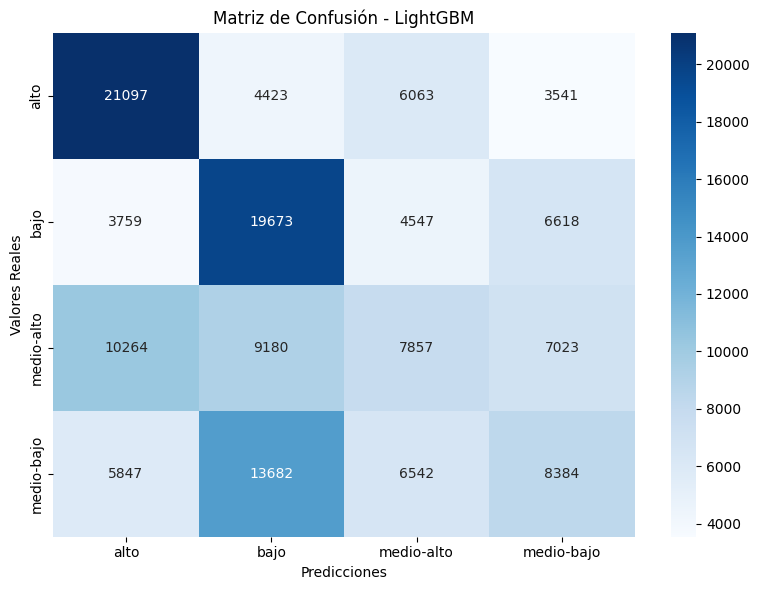


Top 10 características más importantes:
                                              feature     importance
30   ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones  226642.944957
1                                              coef_1  100060.763453
57                        ESTU_PAGOMATRICULAPROPIO_Si   55289.795672
29    ESTU_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil   43188.622829
0                                             PERIODO   26641.060589
27  ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millo...   24130.998151
66            FAMI_EDUCACIONMADRE_Primaria incompleta   23604.381670
26  ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millone...   21698.662860
16                      ESTU_PRGM_DEPARTAMENTO_BOGOTÁ   20210.743229
22                       ESTU_PRGM_DEPARTAMENTO_OTHER   17381.608327


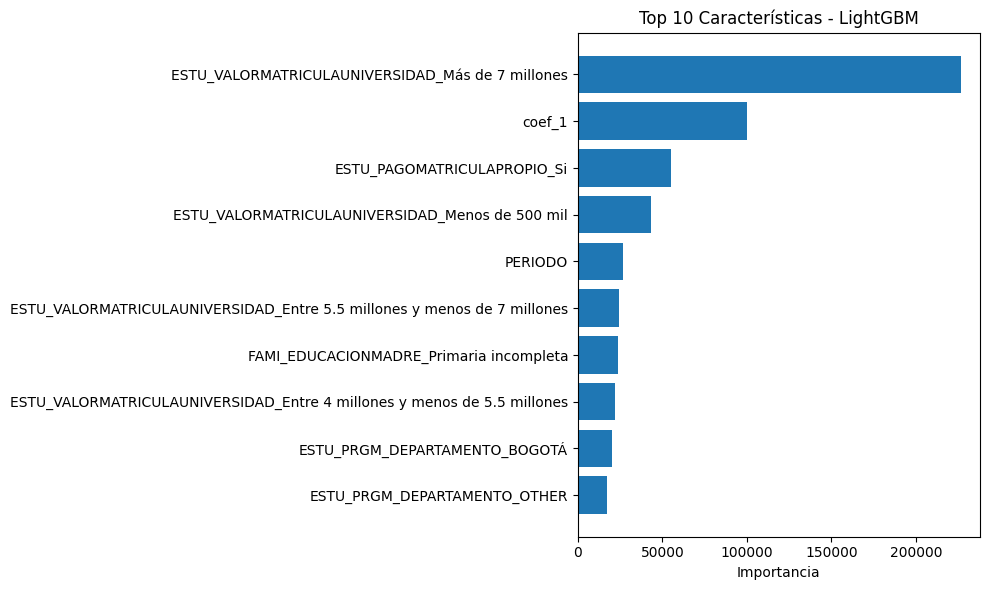


13. VALIDACIÓN CRUZADA
----------------------------------------
Validación Cruzada (3 folds):
  Fold 1: 0.4056
  Fold 2: 0.4032
  Fold 3: 0.4056

Precisión promedio: 0.4048 (+/- 0.0023)

14. GUARDAR RESULTADOS
----------------------------------------
Resultados guardados en 'kaggle_notebook_results.txt'
Importancia de características guardada en 'kaggle_feature_importance.csv'

NOTEBOOK KAGGLE - COMPLETADO
Mejor modelo: LightGBM
Características utilizadas: 71
Precisión validación: 0.4116
CV Precisión: 0.4048 (+/- 0.0023)
Archivo submission: submission.csv
Predicciones generadas: 296786
Memoria liberada

🎯 LISTO PARA KAGGLE!
📁 Archivo a subir: submission.csv
📊 Formato: ID, RENDIMIENTO_GLOBAL
📈 296786 predicciones generadas


In [2]:
# GUARDAR RESULTADOS
print("\n14. GUARDAR RESULTADOS")
print("-" * 40)

# Compilar resultados finales
results_summary = {
    'modelo_final': best_model_name,
    'caracteristicas_utilizadas': len(selected_feature_names),
    'precision_validacion': best_accuracy,
    'cv_precision_promedio': cv_scores.mean(),
    'cv_precision_std': cv_scores.std(),
    'archivo_submission': submission_filename,
    'columna_id': id_column,
    'columna_objetivo': target_column,
    'clases_objetivo': list(class_names),
    'numero_predicciones': len(test_predictions_labels)
}

# Guardar resultados
with open('kaggle_notebook_results.txt', 'w') as f:
    f.write("RESULTADOS NOTEBOOK KAGGLE\n")
    f.write("="*50 + "\n\n")
    for key, value in results_summary.items():
        f.write(f"{key}: {value}\n")

    f.write(f"\nTOP 10 CARACTERÍSTICAS:\n")
    f.write("-" * 30 + "\n")
    for i, row in feature_importance.head(10).iterrows():
        f.write(f"{row['feature']}: {row['importance']:.6f}\n")

    f.write(f"\nDISTRIBUCIÓN DE PREDICCIONES:\n")
    f.write("-" * 30 + "\n")
    for label, count in zip(unique, counts):
        f.write(f"{label}: {count} ({count/len(test_predictions_labels)*100:.1f}%)\n")

print("Resultados guardados en 'kaggle_notebook_results.txt'")

# Guardar características importantes
feature_importance.to_csv('kaggle_feature_importance.csv', index=False)
print("Importancia de características guardada en 'kaggle_feature_importance.csv'")

print("\n" + "="*80)
print("NOTEBOOK KAGGLE - COMPLETADO")
print("="*80)
print(f"Mejor modelo: {best_model_name}")
print(f"Características utilizadas: {len(selected_feature_names)}")
print(f"Precisión validación: {best_accuracy:.4f}")
print(f"CV Precisión: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Archivo submission: {submission_filename}")
print(f"Predicciones generadas: {len(test_predictions_labels)}")
print("="*80)

# Limpiar memoria al final
import gc
gc.collect()
print("Memoria liberada")

print(f"\nLISTO PARA KAGGLE!")
print(f"Archivo a subir: {submission_filename}")
print(f"Formato: {id_column}, {target_column}")
print(f"{len(test_predictions_labels)} predicciones generadas")